<a href="https://colab.research.google.com/github/mprovenc/ids2018/blob/master/CSE_CIC_IDS2018_ids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly-Based Intrusion Detection using Machine Learning

The CSE-CIC-IDS2018 publicly available dataset assembled by the Canadian Institute for Cybersecurity was retrieved from AWS. 

[IDS 2018 Dataset](https://www.unb.ca/cic/datasets/ids-2018.html)

This dataset was assembled by building a network infrastructure and performing a series of attacks on the systems in that infrastructure over the course of a week. Wireshark was used to capture and store packet information in PCAP files. These PCAP files were then fed through CICFlowMeter to extract information into .csv format and each packet was labeled as either 'benign' or 'anomalous'. 

On Thursday and Friday of that week, brute Force web, cross-site scripting, and SQL injection attacks were performed. The focus of this research was to use the packet information to train a deep learning model to recognize these kinds of web-based attacks and label them appropriately.

The ultimate goal is that this could potentially be used as a back-end engine for an anomaly-based intrusion detection system.

Most of the data preparation tips were taken from the paper entitled "Increasing the Performance of Machine Learning-Based IDSs on an Imbalanced and Up-to-Date Dataset" by G. Karatas, O. Demir, and O.K. Sahingoz (2020). This paper was retrieved at the following location:

[Increasing the Performance of Machine Learning-Based IDSs on an Imbalanced and Up-to-Date Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8993711)

Though many suggestions were taken from them, the implementation is completely my own.

In [2]:
import pandas as pd 

thursday = pd.read_csv("/content/drive/My Drive/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv")
friday = pd.read_csv("/content/drive/My Drive/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv")

both_days = pd.concat([thursday,friday], axis=0, join='outer', ignore_index=False)

both_days.sample(10)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
25920,51629,6,23/02/2018 01:05:57,4945260,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.404428,4.945260e+06,0.000000e+00,4945260,4945260,4945260,4.945260e+06,0.000000e+00,4945260,4945260,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,0.404428,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,237,-1,0,20,0.0,0.000000e+00,0,0,0.000000e+00,0.000000,0,0,Benign
198847,443,6,23/02/2018 11:20:22,98987,7,7,733,3762,373,0,104.714286,148.887781,1460,0,537.428571,643.336060,4.541000e+04,141.432713,7.614385e+03,1.350506e+04,49952,15,87218,1.453633e+04,1.817898e+04,49971,184,87348,1.455800e+04,2.767850e+04,70355,23,0,0,0,0,152,152,70.716357,70.716357,0,1460,299.666667,490.470134,240560.952381,0,0,0,1,0,0,0,0,1,321.071429,104.714286,537.428571,0,0,0,0,0,0,7,733,7,3762,8192,245,3,20,0.0,0.000000e+00,0,0,0.000000e+00,0.000000,0,0,Benign
140812,53,17,22/02/2018 10:23:51,206942,2,2,76,164,38,38,38.000000,0.000000,82,82,82.000000,0.000000,1.159745e+03,19.329087,6.898067e+04,6.113022e+04,116717,81,90144,9.014400e+04,0.000000e+00,90144,90144,81,8.100000e+01,0.000000e+00,81,81,0,0,0,0,16,16,9.664544,9.664544,38,82,55.600000,24.099793,580.800000,0,0,0,0,0,0,0,0,1,69.500000,38.000000,82.000000,0,0,0,0,0,0,2,76,2,164,-1,-1,1,8,0.0,0.000000e+00,0,0,0.000000e+00,0.000000,0,0,Benign
29977,49771,6,23/02/2018 09:00:41,59,3,1,86,0,55,0,28.666667,27.574142,0,0,0.000000,0.000000,1.457627e+06,67796.610169,1.966667e+01,1.900877e+01,39,1,59,2.950000e+01,4.030509e+01,58,1,0,0.000000e+00,0.000000e+00,0,0,1,0,0,0,60,20,50847.457627,16949.152542,0,55,28.200000,27.544509,758.700000,0,1,0,0,1,0,0,0,0,35.250000,28.666667,0.000000,0,0,0,0,0,0,3,86,1,0,119,0,1,20,0.0,0.000000e+00,0,0,0.000000e+00,0.000000,0,0,Benign
251664,3389,6,22/02/2018 10:06:40,3955885,14,9,1456,1731,741,0,104.000000,195.013609,1179,0,192.333333,386.074475,8.056351e+02,5.814123,1.798130e+05,2.679653e+05,953142,70,3955885,3.042988e+05,3.675871e+05,1252060,3837,3950739,4.938424e+05,4.088065e+05,1059535,107421,0,0,0,0,292,192,3.539031,2.275091,0,1179,132.791667,275.678448,75998.606884,0,0,1,1,0,0,0,1,0,138.565217,104.000000,192.333333,0,0,0,0,0,0,14,1456,9,1731,8192,62544,7,20,0.0,0.000000e+00,0,0,0.000000e+00,0.000000,0,0,Benign
856848,53,17,22/02/2018 04:56:04,243,1,1,38,134,38,38,38.000000,0.000000,134,134,134.000000,0.000000,7.078189e+05,8230.452675,2.430000e+02,0.000000e+00,243,243,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,8,8,4115.226337,4115.226337,38,134,70.000000,55.425626,3072.000000,0,0,0,0,0,0,0,0,1,105.000000,38.000000,134.000000,0,0,0,0,0,0,1,38,1,134,-1,-1,0,8,0.0,0.000000e+00,0,0,0.000000e+00,0.000000,0,0,Benign
941702,80,6,23/02/2018 02:09:44,829,3,4,161,488,161,0,53.666667,92.953393,488,0,122.000000,244.000000,7.828709e+05,8443.908323,1.381667e+02,9.294389e+01,231,0,419,2.095000e+02,1.152584e+02,291,128,598,1.993333e

# Class imbalance
The data in this data set is currently extremely imbalanced. The number of packets labeled as "benign" is around 2 million, while anomalous packets number less than a thousand. The following couple of cells illustrate this and serve as part of the exploratory data analysis.

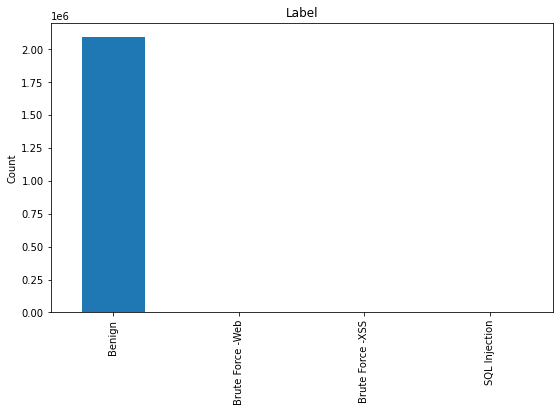

In [3]:
import matplotlib.pyplot as plt

# Getting a sense of what the distribution of each column looks like
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
both_days['Label'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Label');

plt.tight_layout()
plt.show()

In [4]:
both_days['Label'].value_counts()

Benign              2096222
Brute Force -Web        611
Brute Force -XSS        230
SQL Injection            87
Name: Label, dtype: int64

# Cleaning the Data

The following several cells clean the data by filling in null values with zeros, translating infinity values to appropriate numeric values, splitting the timestamp into a series of numeric cells, translating string values to numeric values (particularly the labels, which will form the `y` vector).

In [0]:
both_days = both_days.fillna(0)

In [6]:
import numpy as np

max_flow_bytes = both_days.loc[both_days['Flow Byts/s'] != np.inf, 'Flow Byts/s'].max()
max_flow_pkts = both_days.loc[both_days['Flow Pkts/s'] != np.inf, 'Flow Pkts/s'].max()

print(max_flow_bytes, max_flow_pkts)

1806642857.1428602 4000000.0


In [0]:
both_days['Flow Byts/s'].replace(np.inf,max_flow_bytes+1,inplace=True)
both_days['Flow Pkts/s'].replace(np.inf,max_flow_pkts+1,inplace=True)

In [0]:
both_days[['Date','Time']] = both_days['Timestamp'].str.split(expand=True)

In [0]:
both_days = both_days.drop('Timestamp', 1)

In [10]:
both_days.sample(10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,...,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Date,Time
161720,49865,6,78,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,2.564103e+04,7.800000e+01,0.000000e+00,78,78,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,20,20,1.282051e+04,12820.512821,0,...,0.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,172,255,0,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign,23/02/2018,09:24:50
264752,39077,6,85990629,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,2.325835e-02,8.599063e+07,0.000000e+00,85990629,85990629,85990629,8.599063e+07,0.000000e+00,85990629,85990629,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,2.325835e-02,0.000000,0,...,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,62566,-1,0,20,0.000000,0.000000,0,0,8.599063e+07,0.000000,85990629,85990629,Benign,22/02/2018,10:15:55
562142,27476,6,142,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,1.408451e+04,1.420000e+02,0.000000e+00,142,142,142,1.420000e+02,0.000000e+00,142,142,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,1.408451e+04,0.000000,0,...,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,255,-1,0,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign,23/02/2018,09:19:15
442533,443,6,118222921,17,19,1062,5632,412,0,62.470588,109.768573,1430,0,296.421053,518.645385,56.621846,3.045095e-01,3.377798e+06,1.381948e+07,58920558,0,118222921,7.388933e+06,2.005021e+07,58920558,33,118068173,6.559343e+06,1.901656e+07,59077309,0,0,0,0,0,352,392,1.437961e-01,0.160713,0,...,180.918919,392.972177,154427.132132,0,0,0,1,0,0,0,0,1,185.944444,62.470588,296.421053,0,0,0,0,0,0,17,1062,19,5632,8192,180,8,20,328992.500000,244851.986442,502129,155856,5.870448e+07,305581.145237,58920558,58488401,Benign,23/02/2018,05:04:56
587295,53,17,20571,1,1,44,72,44,44,44.000000,0.000000,72,72,72.000000,0.000000,5639.006368,9.722425e+01,2.057100e+04,0.000000e+00,20571,20571,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,8,8,4.861212e+01,48.612124,44,...,53.333333,16.165808,261.333333,0,0,0,0,0,0,0,0,1,80.000000,44.000000,72.000000,0,0,0,0,0,0,1,44,1,72,-1,-1,0,8,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign,22/02/2018,09:39:19
592444,80,6,5153018,4,4,97,231,97,0,24.250000,48.500000,231,0,57.750000,115.500000,63.652019,1.552488e+00,7.361454e+05,1.920399e+06,5090893,41,62125,2.070833e+04,3.557695e+04,61789,109,5152832,1.717611e+06,2.974520e+06,5152291,228,0,0,0,0,92,92,7.762441e-01,0.776244,0,...,36.444444,79.699610,6352.027778,0,0,0,1,0,0,0,0,1,41.000000,24.250000,57.750000,0,0,0,0,0,0,4,97,4,231,8192,141,1,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign,23/02/2018,08:57:56
235375,50911,6,1,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000e+00,1,1,1,1.000000e+00,0.000000e+00,1,1,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0

In [0]:
both_days['Time'] = both_days['Time'].str.replace(':','')
both_days['Date'] = both_days['Date'].str.replace('/','')

In [12]:
both_days.sample(10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,...,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Date,Time
211941,443,6,5935977,8,6,355,3292,198,0,44.375000,75.864423,1460,0,548.666667,711.681577,614.389173,2.358500,4.566136e+05,1.582049e+06,5719840,0,5935977,8.479967e+05,2.149243e+06,5719840,18,37944,7.588800e+03,1.010224e+04,18694,0,0,0,0,0,172,132,1.347714,1.010786,0,...,243.133333,500.570941,250571.266667,0,0,0,1,0,0,0,0,0,260.500000,44.375000,548.666667,0,0,0,0,0,0,8,355,6,3292,8192,123,3,20,216119.0,0.0,216119,216119,5719840.0,0.000000,5719840,5719840,Benign,22022018,015313
176954,53,17,617,1,1,74,202,74,74,74.000000,0.000000,202,202,202.000000,0.000000,447325.769854,3241.491086,6.170000e+02,0.000000e+00,617,617,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,8,8,1620.745543,1620.745543,74,...,116.666667,73.900834,5461.333333,0,0,0,0,0,0,0,0,1,175.000000,74.000000,202.000000,0,0,0,0,0,0,1,74,1,202,-1,-1,0,8,0.0,0.0,0,0,0.0,0.000000,0,0,Benign,23022018,033156
222055,36346,6,87871227,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.022761,8.787123e+07,0.000000e+00,87871227,87871227,87871227,8.787123e+07,0.000000e+00,87871227,87871227,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,0.022761,0.000000,0,...,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,63324,-1,0,20,0.0,0.0,0,0,87871227.0,0.000000,87871227,87871227,Benign,22022018,112249
769165,80,6,5929796,4,4,97,231,97,0,24.250000,48.500000,231,0,57.750000,115.500000,55.313876,1.349119,8.471137e+05,2.213963e+06,5867643,40,62153,2.071767e+04,3.555418e+04,61772,111,5929566,1.976522e+06,3.422978e+06,5929037,216,0,0,0,0,92,92,0.674559,0.674559,0,...,36.444444,79.699610,6352.027778,0,0,0,1,0,0,0,0,1,41.000000,24.250000,57.750000,0,0,0,0,0,0,4,97,4,231,8192,141,1,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign,23022018,090100
213206,0,0,112638062,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026634,5.631903e+07,2.828427e+01,56319051,56319011,112638062,5.631903e+07,2.828427e+01,56319051,56319011,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0.026634,0.000000,0,...,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56319031.0,28.284271,56319051,56319011,Benign,22022018,025443
88456,3389,6,4069622,13,8,1442,1731,725,0,110.923077,196.522035,1179,0,216.375000,405.464791,779.679292,5.160184,2.034811e+05,2.467631e+05,953123,79,4069622,3.391352e+05,3.455471e+05,1303101,24613,4010935,5.729907e+05,3.040995e+05,953123,164302,0,0,0,0,272,172,3.194400,1.965785,0,...,144.227273,283.777735,80529.803030,0,0,1,1,0,0,0,1,0,151.095238,110.923077,216.375000,0,0,0,0,0,0,13,1442,8,1731,8192,62643,7,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign,23022018,050635
553458,445,6,285947,3,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,13.988606,9.531567e+04,1.633310e+05,283911,86,285947,1.429735e+05,1.994373e+05,283997,1950,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,72,32,10.491455,3.497152,0,...,0.000000,0

In [0]:
both_days['Init Fwd Win Byts Neg'] = [1 if x < 0 else 0 for x in both_days['Init Fwd Win Byts']]

In [0]:
both_days['Init Bwd Win Byts Neg'] = [1 if x < 0 else 0 for x in both_days['Init Bwd Win Byts']]

In [15]:
both_days['Label'].unique()

array(['Benign', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection'],
      dtype=object)

In [0]:
legend = {'Benign': 0, 'Brute Force -Web': 1, 'Brute Force -XSS': 1, 'SQL Injection': 2}

both_days['Label'] = [legend[item] for item in both_days['Label']]

In [0]:
from sklearn.utils import shuffle

both_days = shuffle(both_days)

In [0]:
both_days = both_days[[c for c in both_days if c not in ['Label']] + ['Label']]

# Addressing Class Imbalance with SMOTE
To address the problem of class imbalance, I will try to implement the Synthetic Minority Oversampling Technique (SMOTE). This will synthesize information from the existing "anomalous" exemplars to generate new samples. In this case, I am using the k nearest neighbors method to select closely related exemplars and generate a new sample point from these existing samples. Ultimately, no new information will be added to the model, but it will serve to mitigate the problem of class imbalance.

In [0]:
from imblearn.over_sampling import SMOTE

X = both_days.iloc[:,:-1]
y = both_days.iloc[:,-1]

seed=100
k=1

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
X_res, y_res = sm.fit_resample(X, y)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from collections import Counter
from numpy import where
from matplotlib import pyplot

counter = Counter(y_res)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
  row_ix = where(y_res == label)[0]
  print(row_ix)
  pyplot.scatter(X_res[row_ix, 0], X_res[row_ix, 1], label=str(label), alpha=0.2)
pyplot.legend()
pyplot.show()

# ...And then my computer threw a tantrum

I started running into RAM issues at this point due to the size of the data set (2 million+ data points with about 80 features). In addition to this, SMOTE adds new samples which expand the dataset even more... My RAM just couldn't take it.

Here are the next steps which I would take to continue this project:
1. Build a new computer that can actually do stuff.
2. Fit an existing deep learning model and train it on the cleaned up, oversampled data. I have read a number of papers about people who have had success with a Restricted Boltzmann Machine for intrusion detection. There are also some recurrent neural network architectures like long short-term memory that have been successful.
